In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [4]:
# Load the dataset
df = pd.read_csv(r"C:\Users\poona\Downloads\Fraud.csv")

# Display basic information
from sklearn.feature_selection import RFE
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assume df is already loaded from a previous cell
chunk_size = 100000  # Choose an appropriate size based on your system's memory
num_chunks = len(df) // chunk_size + 1

# Initialize an empty list to collect processed chunks
processed_chunks = []

for i in range(num_chunks):
    # Slice the DataFrame into chunks
    chunk = df.iloc[i*chunk_size:(i+1)*chunk_size]
    
    # Identify categorical and numeric columns
    categorical_cols = chunk.select_dtypes(include=['object', 'category']).columns
    numeric_cols = chunk.select_dtypes(include=['number']).columns
    
    # Handle missing values
    chunk[numeric_cols] = chunk[numeric_cols].fillna(chunk[numeric_cols].median())
    chunk[categorical_cols] = chunk[categorical_cols].fillna(chunk[categorical_cols].mode().iloc[0])
    
    # Label encode categorical variables to avoid high memory usage
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        chunk[col] = le.fit_transform(chunk[col])
        label_encoders[col] = le
    
    # Downcast only numeric columns to save memory
    chunk[numeric_cols] = chunk[numeric_cols].apply(pd.to_numeric, downcast='float')
    
    # Append the processed chunk to the list
    processed_chunks.append(chunk)

# Concatenate all processed chunks back into a single DataFrame
df_processed = pd.concat(processed_chunks, axis=0, ignore_index=True)

# Now df_processed is ready for further processing or model training


C:\Users\poona\AppData\Local\Temp\ipykernel_16704\805142091.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[numeric_cols] = chunk[numeric_cols].fillna(chunk[numeric_cols].median())
C:\Users\poona\AppData\Local\Temp\ipykernel_16704\805142091.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk[categorical_cols] = chunk[categorical_cols].fillna(chunk[categorical_cols].mode().iloc[0])
C:\Users\poona\AppData\Local\Temp\ipykernel_16704\805142091.py:27: SettingWithCopyWarning: 
A value is trying 

In [5]:
# Check for missing values
print(df.isnull().sum())

# Impute missing values with median
df.fillna(df.median(), inplace=True)

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


TypeError: Cannot convert [['PAYMENT' 'PAYMENT' 'TRANSFER' ... 'CASH_OUT' 'TRANSFER' 'CASH_OUT']
 ['C1231006815' 'C1666544295' 'C1305486145' ... 'C1162922333'
  'C1685995037' 'C1280323807']
 ['M1979787155' 'M2044282225' 'C553264065' ... 'C1365125890'
  'C2080388513' 'C873221189']] to numeric

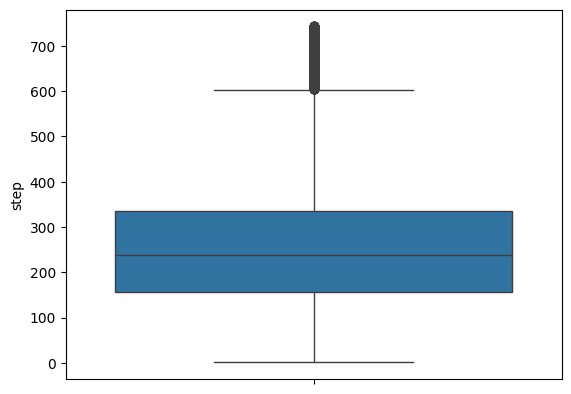

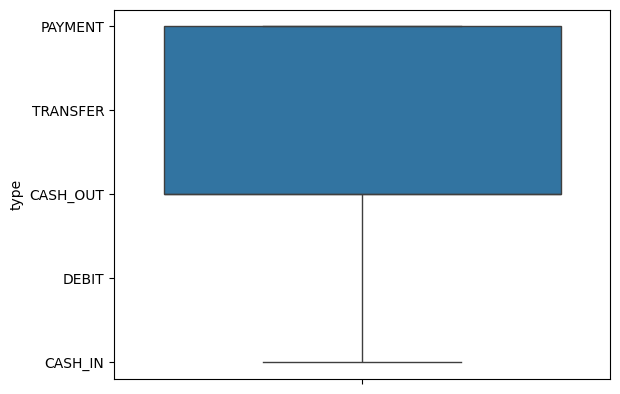

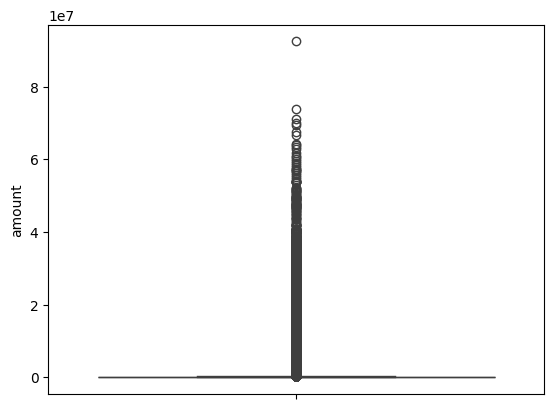

In [ ]:
# Visualize outliers using boxplots
for column in df.columns:
    sns.boxplot(df[column])
    plt.show()

# Remove outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]


In [5]:


# Step 1: Data Cleaning
# Separate numeric and categorical features
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

# Separate target variable
target = 'isFraud'  # Assuming 'fraud_label' is the name of the target variable
X = df.drop(columns=[target
y = df[target]

# Create transformers for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply the transformations to the dataset
X_preprocessed = preprocessor.fit_transform(X)

# Convert back to DataFrame to handle features easily
X_preprocessed_df = pd.DataFrame(X_preprocessed.toarray())

# Step 2: Feature Engineering
# Splitting data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed_df, y, test_size=0.3, random_state=42)

# Step 3: Model Development
# Model selection and training (Random Forest as an example)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Step 4: Model Evaluation
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_prob)}")

# Plotting ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label="ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# Step 5: Key Factors Analysis
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': range(X_preprocessed_df.shape[1]), 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# Step 6: Actionable Plan and Prevention
# Assuming some hypothetical key factors for demonstration
key_factors = feature_importance_df.head(5)['Feature'].tolist()
print(f"Key Factors predicting fraud: {key_factors}")

# Recommendations for prevention based on key factors (e.g., stricter monitoring, enhanced authentication)
# This would involve domain knowledge and company-specific policies.

# Step 7: Post-Implementation Monitoring
# Plan to monitor metrics like fraud detection rate, false positive rate over time
# (This would typically involve setting up a monitoring pipeline, beyond the scope of this script)


   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 co

ValueError: A given column is not a column of the dataframe

In [4]:
# Inspect column names
print(df.columns)



Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')
